In [1]:
import torch
from d2l import torch as d2l

# 多输入多输出通道
之前仅仅讨论单通道的情况, 但是实际的彩色图像(`RGB`图像)中, 存在多个通道, 比如每一个 `RGB` 输入图像具有 $3 \times h \times w$的形状, 这一个大小为 $3$ 的轴称为通道维度

## 多输入通道
当输入包含多个通道的时候, 需要构建一个与输入数据具有相同输入通道数的卷积核, 以便与输入数据进行互相关运算, 假设输入通道数为 $c_i$, 那么卷积核输出通道数也需要 $c_i$

当 $c_i \gt 1$ 的时候, 卷积核的每一个输入通道将包含形状为 $k_h \times k_w$的张量, 把这些张量连接在一起可以构成 $c_i \times k_h \times k_w$的卷积核, 同时如果输入通道数 $in \ge 1$, 但是输出通道数 $out = 1$ 的时候, 可能是每一个通道的卷积核和输入的对应通道进行互相关运算, 得到的结果再进行相加即可:
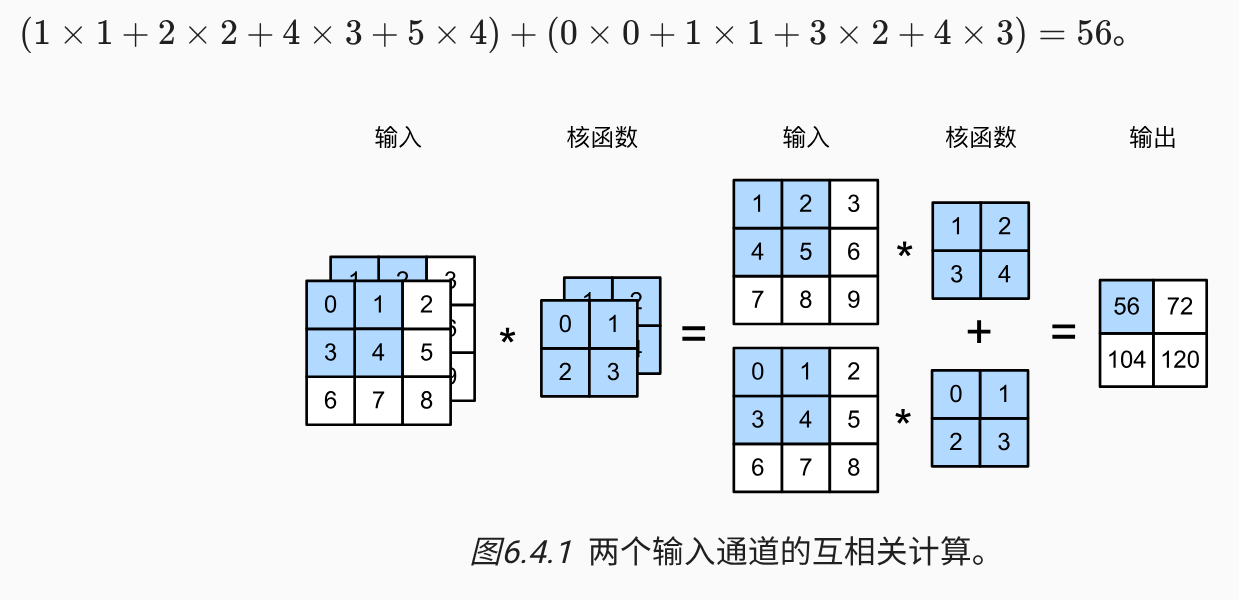

In [8]:
def corr2d_multi_in(X, K):
    # X,K 的第一个维度就是通道
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K)) # 得到矩阵, 矩阵对应元素相加

In [33]:
X = torch.arange(9).reshape((3, 3))
K = torch.arange(4).reshape((2, 2))
X = torch.stack((X, X))
K = torch.stack((K, K))
corr2d_multi_in(X, K)
K

tensor([[[0, 1],
         [2, 3]],

        [[0, 1],
         [2, 3]]])

## 多输出通道
多输出通道表示可以利用多个不同的通道表示图像的不同特征(比如图像的纹理等特征), 假设使用 $c_i, c_o$分别表示输入和输出通道的数量, 并且使用 $k_h, k_w$表示卷积核的高度和宽度, 为了获取到多个通道的输出,可以构建形状为 $c_i \times k_h \times k_w$ 的卷积核张量, 所以此时卷积核的形状为 $c_o \times c_i \times k_h \times k_w$ **(可以简单把输出的通道理解为 "想要从图像中提取的特征数量", 所以这样各个特征就是分开的, 我们需要提取 $c_o$ 个特征, 并且提取一个特征需要使用 $c_i \times k_h \times k_w$大小的卷积核, 所以提取全部的 $c_o$ 特特征需要使用 $c_o \times c_i \times k_h \times k_w$ 大小的卷积核, 注意到卷积核必须要提取输入的所有特征从而得到输入的单一特征)**

In [34]:
# 多输出通道的情况
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)
K

tensor([[[0, 1],
         [2, 3]],

        [[0, 1],
         [2, 3]]])

In [35]:
print(K.shape)
K = torch.stack((K, K + 1, K + 2), 0)
K

torch.Size([2, 2, 2])


tensor([[[[0, 1],
          [2, 3]],

         [[0, 1],
          [2, 3]]],


        [[[1, 2],
          [3, 4]],

         [[1, 2],
          [3, 4]]],


        [[[2, 3],
          [4, 5]],

         [[2, 3],
          [4, 5]]]])

In [36]:
corr2d_multi_in_out(X, K)

tensor([[[ 38.,  50.],
         [ 74.,  86.]],

        [[ 54.,  74.],
         [114., 134.]],

        [[ 70.,  98.],
         [154., 182.]]])

## 1 x 1 卷积层
$1 \times 1$卷积, 也就是 $k_h = k_w = 1$, 看起来没有什么作用(考虑输出单一特征, 对于输出位置的像素, 仅仅是对于对应输入位置像素的各个通道的加权叠加, 没有考虑到向零像素的相关特征), 可以发现 $1 \times 1$大小的卷积核失去了卷积层的特有能力--高度和宽度上相邻元素相互作用, 唯一计算发生在通道上(同一个位置像素的加权求和), 比如使用 $1 \times 1$ 卷积进行运算的过程如下:
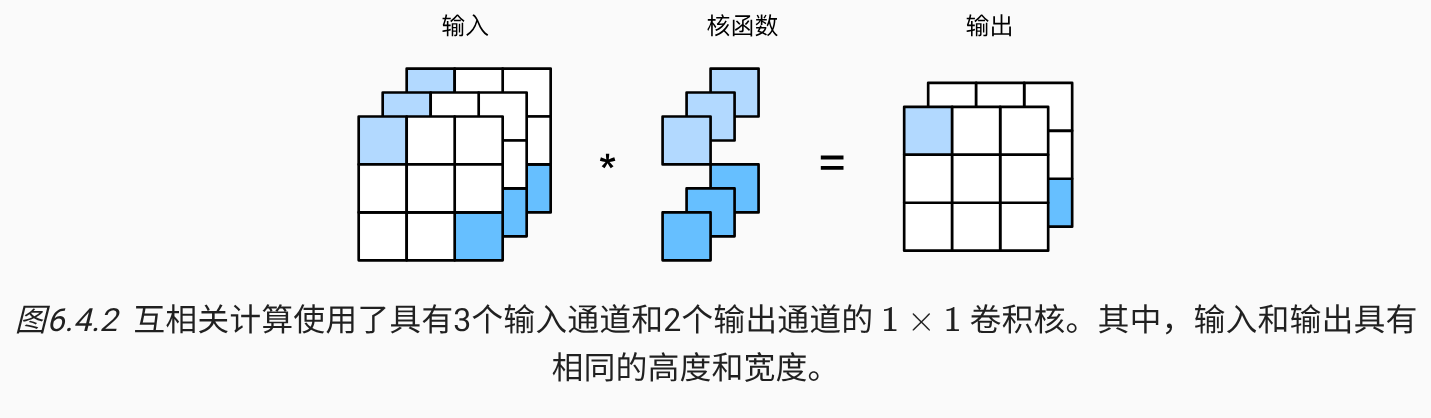

In [39]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0] # 输出通道数
    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o, c_i))  # 同一行表示该特征需要的每一个通道加权值
    Y = torch.mm(K, X)
    return Y.reshape((c_o, h, w))

In [43]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
# 注意这里 torch.func 表示对于整个矩阵执行函数
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6 

所以可以发现, 如果针对于图片中的单个像素, 各个通道就是输入的特征, $1 \times 1$ 的卷积层相当于对于
每一个像素的全连接层, 批量就是图像大小, 特征就是通道数, 加权就是对应卷积核, 输出的就是输出通道个特征